<a href="https://colab.research.google.com/github/LuisDi98/Audio_a_Lesco/blob/dev/Audio_To_LESCO_models_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install dependencies
! pip install datasets
! pip install transformers
! pip install -U openai-whisper
! pip install git+https://github.com/openai/whisper.git 
! pip install jiwer

# Get Dataset
CIEMPIESS_TEST

In [2]:
#Load the dataset
from datasets import load_dataset, load_metric, Audio
import whisper
ds=load_dataset("ciempiess/ciempiess_test", split="test")

#Downsample to 16kHz
ds = ds.cast_column("audio", Audio(sampling_rate=16_000))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset ciempiess_test downloaded and prepared to /root/.cache/huggingface/datasets/ciempiess___ciempiess_test/ciempiess_test/1.0.0/6308ec4b2e9db78ec4aa6169117a8b2e2b3ac399c99501e57de918b528539b0b. Subsequent calls will reuse this data.


In [ ]:
ds

Dataset({
    features: ['audio_id', 'audio', 'speaker_id', 'gender', 'duration', 'normalized_text'],
    num_rows: 3558
})

In [ ]:
ds[0]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/024bce9383676d0a3a6afc0dd8423b344044040363dd48ff5402220707a9d22c/test/male/M_07/CMPT_M_07_0074.flac',
 'array': array([-0.00192261, -0.00234985, -0.00158691, ..., -0.00839233,
        -0.00900269, -0.00698853]),
 'sampling_rate': 16000}

In [ ]:
ds.num_rows

3558

#Whisper-large
* De momento no ocupamos los inputs, esta es una manera más sencilla.
* Queda pendiente probar wav2vec2-large-xlsr-53-spanish-ep5-944h: https://huggingface.co/carlosdanielhernandezmena/wav2vec2-large-xlsr-53-spanish-ep5-944h
* Comparar con el word error rate


In [16]:
large_model = whisper.load_model("large")
# Transcribe from audio to text with the first sample
sample = ds[0]["audio"]["path"]
result = model.transcribe(sample)
print("Whisper result: ",result["text"])
print("Normalized_text of the sample: ",ds[0]["normalized_text"])

100%|██████████████████████████████████████| 2.87G/2.87G [00:22<00:00, 136MiB/s]


Whisper result:   pues esta la libertad de las posiciones de haber quien es pasivo, que en el activo la muchas cosas, ¿no? pero...
Normalized_text of the sample:  pues está la libertá de las posiciones de a ver quién es pasivo quién es activo blablablá muchas cosas no pero


#Whisper-medium

###TO DO: 
Usar el dataset en espaniol y probar el modelo.

Buscar una metrica adecuada y una biblioteca para el testing

Ver porque esta dando samples en ingles y no espaniol al usar el dataset de ciempiess

In [15]:
medium_model = whisper.load_model("medium")
# Transcribe from audio to text with the first sample
sample = ds[0]["audio"]["path"]
result = model.transcribe(sample)
print("Whisper result: ",result["text"])
print("Normalized_text of the sample: ",ds[0]["normalized_text"])

Whisper result:   pues esta la libertad de las posiciones de haber quien es pasivo, que en el activo la muchas cosas, ¿no? pero...
Normalized_text of the sample:  pues está la libertá de las posiciones de a ver quién es pasivo quién es activo blablablá muchas cosas no pero


In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_dataset

# load model and processor
processor = WhisperProcessor.from_pretrained("openai/whisper-medium")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-medium")
forced_decoder_ids = processor.get_decoder_prompt_ids(language="spanish", task="transcribe")


# load dummy dataset and read audio files
ds=load_dataset("ciempiess/ciempiess_test", split="test")
ds = ds.cast_column("audio", Audio(sampling_rate=16_000))
sample = ds[0]["audio"]
input_features = processor(sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt").input_features 
print(input_features)
# generate token ids
predicted_ids = model.generate(input_features)
print(predicted_ids)
# decode token ids to text
transcription = processor.batch_decode(predicted_ids, skip_special_tokens=False)
print(transcription)

transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
print(transcription)


tensor([[[-0.1399,  0.5492,  0.2900,  ..., -0.7534, -0.7534, -0.7534],
         [ 0.2928,  0.3964,  0.2335,  ..., -0.7534, -0.7534, -0.7534],
         [ 0.2252,  0.2252,  0.0790,  ..., -0.7534, -0.7534, -0.7534],
         ...,
         [-0.6674, -0.6745, -0.5624,  ..., -0.7534, -0.7534, -0.7534],
         [-0.5837, -0.6500, -0.5296,  ..., -0.7534, -0.7534, -0.7534],
         [-0.5518, -0.7030, -0.6630,  ..., -0.7534, -0.7534, -0.7534]]])


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[50258, 50259, 50359, 50363,  1042,    11,   456,   307,   264,  5645,
           295,   264,  8432,    11,   295,  2577,   567,   307, 14975,    11,
           567,   307,  4967,    11, 12288, 12288, 12288,    11,   867,   721,
            11,   558,    30,   583,   485, 50257]])
['<|startoftranscript|><|en|><|transcribe|><|notimestamps|> Well, there is the freedom of the positions, of seeing who is passive, who is active, blah blah blah, many things, right? But...<|endoftext|>']
[' Well, there is the freedom of the positions, of seeing who is passive, who is active, blah blah blah, many things, right? But...']


#Whisper-tiny

In [4]:
model = whisper.load_model("tiny")
# Transcribe from audio to text with the first sample
sample = ds[0]["audio"]["path"]
result = model.transcribe(sample)
print("Whisper result: ",result["text"])
print("Normalized_text of the sample: ",ds[0]["normalized_text"])

100%|█████████████████████████████████████| 72.1M/72.1M [00:02<00:00, 34.6MiB/s]


Whisper result:   pues esta la libertad de las posiciones de haber quien es pasivo, que en el activo la muchas cosas, ¿no? pero...
Normalized_text of the sample:  pues está la libertá de las posiciones de a ver quién es pasivo quién es activo blablablá muchas cosas no pero


#Haciendo unas pruebas con el voice detection y wav2vec


In [ ]:
!pip install pydub


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import ipywidgets as widgets
from IPython import display as disp
from IPython.display import display, Audio, clear_output
from google.colab import output
import base64
from pydub import AudioSegment
import io
import tempfile
import librosa

In [ ]:
def record_audio(seconds=3,
                 sample_rate=44100,
                 normalize_db=0.1):
    """Record audio from the browser in colab using javascript.
    Based on: https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
    Args:
      seconds: Number of seconds to record.
      sample_rate: Resample recorded audio to this sample rate.
      normalize_db: Normalize the audio to this many decibels. Set to None to skip
        normalization step.
    Returns:
      An array of the recorded audio at sample_rate.
    """
    # Use Javascript to record audio.
    record_js_code = """
      const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
      const b2text = blob => new Promise(resolve => {
        const reader = new FileReader()
        reader.onloadend = e => resolve(e.srcElement.result)
        reader.readAsDataURL(blob)
      })
      var record = time => new Promise(async resolve => {
        stream = await navigator.mediaDevices.getUserMedia({ audio: true })
        recorder = new MediaRecorder(stream)
        chunks = []
        recorder.ondataavailable = e => chunks.push(e.data)
        recorder.start()
        await sleep(time)
        recorder.onstop = async ()=>{
          blob = new Blob(chunks)
          text = await b2text(blob)
          resolve(text)
        }
        recorder.stop()
      })
      """
    print('Starting recording for {} seconds...'.format(seconds))
    display(disp.Javascript(record_js_code))
    audio_string = output.eval_js('record(%d)' % (seconds * 1000.0))
    print('Finished recording!')
    audio_bytes = base64.b64decode(audio_string.split(',')[1])
    return audio_bytes_to_np(audio_bytes,
                             sample_rate=sample_rate,
                             normalize_db=normalize_db)
    
def audio_bytes_to_np(wav_data,
                      sample_rate=44100,
                      normalize_db=0.1):
    """Convert audio file data (in bytes) into a numpy array.
    Saves to a tempfile and loads with librosa.
    Args:
      wav_data: A byte stream of audio data.
      sample_rate: Resample recorded audio to this sample rate.
      normalize_db: Normalize the audio to this many decibels. Set to None to skip
        normalization step.
    Returns:
      An array of the recorded audio at sample_rate.
    """
    # Parse and normalize the audio.
    audio = AudioSegment.from_file(io.BytesIO(wav_data))
    audio.remove_dc_offset()
    if normalize_db is not None:
        audio.normalize(headroom=normalize_db)
    # Save to tempfile and load with librosa.
    with tempfile.NamedTemporaryFile(suffix='.wav') as temp_wav_file:
        fname = temp_wav_file.name
        audio.export(fname, format='wav')
        audio_np, unused_sr = librosa.load(fname, sr=sample_rate)
    return audio_np

In [ ]:
#@title Record
#@markdown * Set recording time:

SAMPLE_RATE = 44100
record_seconds =   10#@param {type:"number", min:1, max:10, step:1}

def _record_audio(b):
  global audio
  clear_output()
  audio = record_audio(record_seconds, sample_rate=SAMPLE_RATE)
  display(Audio(audio, rate=SAMPLE_RATE))

button = widgets.Button(description="Start recording...")
button.on_click(_record_audio)
display(button)

Starting recording for 10 seconds...


<IPython.core.display.Javascript object>

Finished recording!


# Normalización del texto

Necesitamos normalizar las salidas de whisper, ya que la librería nos proporciona las etiquetas de los audios pero estos están normalizados, este es un paso previo para poder aplicar algunas métricas y que los resultados sean más acertados.

In [5]:
import re
from unicodedata import normalize

def formatText(entryText):
    '''
    Quita las etiquetas xml para extraer el texto, quita caracteres,convierte a minuscula
    y devuelve lista de palabras sin acentos (Como que hace más de una cosa xd)
    '''
    text = re.sub(r'<[^<]+>', "",entryText)
    text = text.lower()
    characters = "#&¿?¡!'-[]()\/''=`,:~}{+|." #-> caracteres innecesarios que se quitan 
    text = ''.join(x for x in text if x not in characters)
    return text    

def deleteAccents(text):
    '''
    Borrar acentos del texto, exceptuando ñ
    #Obtenido de https://ideone.com/YcXaQD (ideone.com)
    '''
    #NFD (Normalization Form Canonical Decomposition) expresion para eliminar diacríticos 
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", normalize( "NFD", text), 0, re.I)
    #NFC (#Normalization Form Canonical Composition) volver a su forma compuesta
    text = normalize( 'NFC', text)
    return text

def deleteSpaces(entryText):
    return " ".join(entryText.split())

def normalizeText(entryText):
    newText = formatText(entryText)
    return deleteSpaces(newText)

def normalizeTextDiacritics(entryText):
    newText = formatText(entryText)
    return deleteSpaces(deleteAccents(newText))

In [ ]:
normalizeText("No sé, honestamente hice hace mu#cho este código, cuando estaba en RIT & XD! [algo aqui] +, PERO me parece ineficiente")

'no se honestamente hice hace mucho este codigo cuando estaba en rit xd algo aqui pero me parece ineficiente'

#WORD ERROR RATE
Se tiene una referencia, en este caso el label del audio y se tiene el texto generado por whisper.

WER = (S+D+I) / N => WER = (S+D+I) / (S+D+C)
​

Dónde:
* S es el número de sustituciones,
* D es el número de eliminaciones,
* I es el número de inserciones,
* C es el número de aciertos,
* N es el número de palabras en la referencia, N = (S + D + C).

A veces tambien se usa el Word accuracy, Auto Speech Recognition. 

Wacc = 1 - WER

In [6]:
import jiwer

def getWER(ref, hyp):
  error = jiwer.wer(ref, hyp)
  return error

In [ ]:
print("WER para el primer simple:", getWER((result["text"]), ds[0]["normalized_text"]))
print((result["text"]),"\n", ds[0]["normalized_text"])

WER para el primer simple: 0.6190476190476191
 pues esta la libertad de las posiciones de haber quien es pasivo, que en el activo la muchas cosas, ¿no? pero... 
 pues está la libertá de las posiciones de a ver quién es pasivo quién es activo blablablá muchas cosas no pero


In [ ]:
print("WER para el primer simple:", getWER(normalizeText(result["text"]), ds[0]["normalized_text"]))
print(normalizeText(result["text"]),"\n", ds[0]["normalized_text"])

WER para el primer simple: 0.42857142857142855
pues esta la libertad de las posiciones de haber quien es pasivo que en el activo la muchas cosas no pero 
 pues está la libertá de las posiciones de a ver quién es pasivo quién es activo blablablá muchas cosas no pero


In [ ]:
print("WER para el primer simple:", getWER(normalizeText(result["text"]), ds[0]["normalized_text"]))
print(normalizeTextDiacritics(result["text"]),"\n", ds[0]["normalized_text"])

WER para el primer simple: 0.42857142857142855
pues esta la libertad de las posiciones de haber quien es pasivo que en el activo la muchas cosas no pero 
 pues está la libertá de las posiciones de a ver quién es pasivo quién es activo blablablá muchas cosas no pero


#WER para todo el data set de Ciempies con Whisper tiny
Tiempo: 25 mins
Resultado: 0.2910024224977097

In [14]:
import numpy as np
WERList = []
for i in range(int(ds.num_rows)):
  sample = ds[i]["audio"]["path"]
  result = model.transcribe(sample)
  textResult = normalizeText(result["text"])
  label = ds[i]["normalized_text"]
  if (textResult!="" and label!=""):
    WERList.append(getWER(textResult, label))

mean = np.mean(WERList)
mean

0.2910024224977097

In [ ]:
import numpy as np

def getWERMetric(model, dataset):
  WERList = []
  for i in range(int(dataset.num_rows)):
    sample = dataset[i]["audio"]["path"]
    result = model.transcribe(sample)
    textResult = normalizeText(result["text"])
    label = dataset[i]["normalized_text"]
    if (textResult!="" and label!=""):
      WERList.append(getWER(textResult, label))
  return np.mean(WERList)

value = getWERMetric(medium_model,ds)
value

#Voice Activity Detector


In [ ]:
pip install malaya-speech

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import malaya_speech
import numpy as np
import librosa
from malaya_speech import Pipeline

In [ ]:
def norm_mel(y, sr):
    mel = librosa.feature.melspectrogram(y, sr = sr, n_mels = 80)
    return np.log10(np.maximum(mel, 1e-10)).T

def plot(y, sr):
    mel = norm_mel(y, sr)
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(y)
    im = axs[1].imshow(np.rot90(mel), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=axs[1])
    plt.show()

In [ ]:
y, sr = malaya_speech.load('probando5.wav')
len(y) / sr

5.888

In [ ]:
import matplotlib.pyplot as plt
import IPython.display as ipd

In [ ]:
ipd.Audio(y, rate = sr)

In [ ]:
plot(y, sr)

TypeError: ignored

In [ ]:
y_ = librosa.effects.trim(y, top_db = 20)[0]
len(y_) / sr

5.696

In [ ]:
ipd.Audio(y_, rate = sr)

#probando otro metodo


In [ ]:
vad = malaya_speech.vad.webrtc()


In [ ]:
y_= malaya_speech.resample(y, sr, 16000)
y_ = malaya_speech.astype.float_to_int(y_)
frames = malaya_speech.generator.frames(y, 30, sr)
frames_ = list(malaya_speech.generator.frames(y_, 30, 16000, append_ending_trail = False))
frames_webrtc = [(frames[no], vad(frame)) for no, frame in enumerate(frames_)]

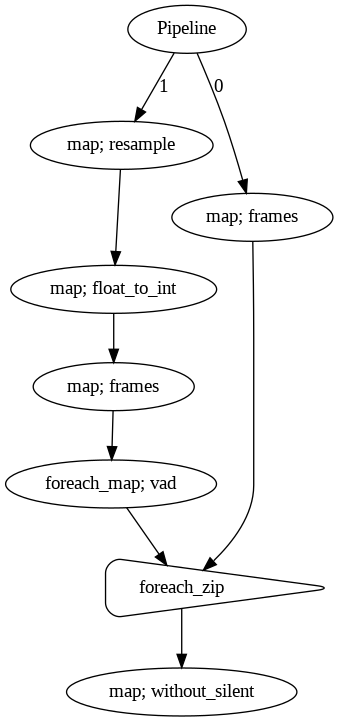

In [ ]:
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    p.map(malaya_speech.resample, old_samplerate = sr, new_samplerate = 16000)
    .map(malaya_speech.astype.float_to_int)
    .map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000,
         append_ending_trail = False)
    .foreach_map(vad)
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent)

p.visualize()

In [ ]:
results = p(y)
results.keys()

dict_keys(['frames', 'resample', 'float_to_int', 'vad', 'foreach_zip', 'without_silent'])

In [ ]:
y_ = malaya_speech.combine.without_silent(frames_webrtc)
y_

array([-0.0001343 , -0.00016788, -0.00020145, ...,  0.        ,
        0.        ,  0.        ])

In [ ]:
ipd.Audio(y_, rate = sr)
